# "Identifying dog breeds using multiple CNNs "
> "Concatnate multiple CNNs as feature extractors and reach an accuracy of 92.5%"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Peiyi Hung
- categories: [category, project]
- image: "images/dogs.png"

# Introduction

In this project I bulid a model for identifying dog breed from a image. This task is originally  [a Kaggle competition](https://www.kaggle.com/c/dog-breed-identification) held three years age. The competition provided 10222 dog images for training and 10357 for evaluating model performance. There are 120 various dog breed to classify in the dataset. I tackle this task by concatenating outputs of convolutional layers of two CNNs that were both pretrained on the ImageNet dataset. This model yields 92.5% accuracy in only 5 epochs. The complete work can be found on this [Kaggle notebook](https://www.kaggle.com/hongpeiyi/using-multiple-pretrained-cnns-with-fastai).

# Prepare the data for modeling

Let's first import the data:

In [1]:
from fastai.vision.all import *

labels = pd.read_csv("../input/dog-breed-identification/labels.csv")
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


Each training image has a unique id and a dog breed label. By simple exploration, you can find that the labels are imbalanced, so I split the dataset into training and valid sets in a stratified manner.

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_ids, valid_ids = next(split.split(labels, labels["breed"]))
labels["is_valid"] = [i in valid_ids for i in range(len(labels))]

labels["id"] = labels["id"].apply(lambda x: x + ".jpg")

In order to feed these images into convolutional neural network, I implement these preprocessing steps:
* Reszie all images 
* Add data augmentation
* Normalize the images with statistics from ImageNet dataset
* Package these images into dataloaders

All these steps can be easily done by fastai's `ImageDateLoaders`:

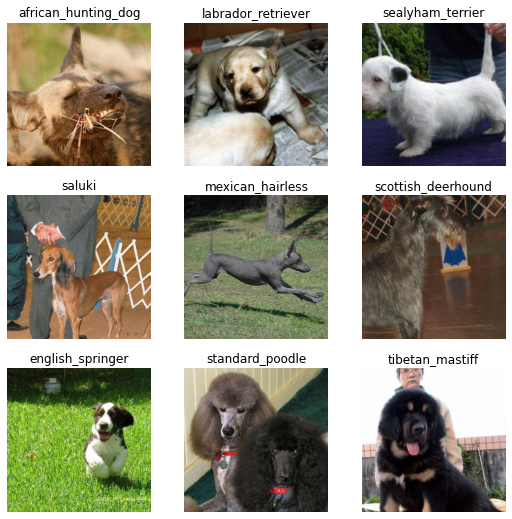

In [3]:
path = "../input/dog-breed-identification/train"

dls = ImageDataLoaders.from_df(labels, path,
                               item_tfms=Resize(460, method="squeeze"),
                               batch_tfms=[*aug_transforms(size=300),
                                           Normalize.from_stats(*imagenet_stats)],
                               bs=32, valid_col="is_valid")
dls.show_batch()

# Extracting feature using various pretrained CNN

After the data is ready, we can start to build our model architecture. 

**Step 1:** Download two pretrained CNNs, chop off the classifiers and set them to evalutaion mode by `.eval()`.

In [ ]:
from torchvision.models import inception_v3

inception = inception_v3(pretrained=True, aux_logits=False)
inception = nn.Sequential(*list(inception.children())[:-2],
                          nn.Flatten()).eval()

In [ ]:
resnet = nn.Sequential(*list(resnet50(pretrained=True).children())[:-1], 
                       nn.Flatten()).eval()

I download pretrained InceptionV3 and resnet50 from the internet. I would like to use these CNNs as feature extractors, so I get rid of the classifiers part and freeze them. 

**Step 2:** Concatenate the output of CNNs as features and Make a new classifier.

In [22]:
class NeuralNet(Module):
    def __init__(self, extractors, hidden_size, vocab_size, device):
        
        self.extractors = extractors
        for conv in self.extractors:
            conv.to(device)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, vocab_size)
        )
        
    def forward(self, x):
        
        features = torch.cat([conv(x) for conv in self.extractors], dim=1)
        
        return self.classifier(features)

The outputs would be used as features and fed into a untrained classifier. Here's what the model attributes indicate:
* `extractors`: list of pretrained CNNs
* `hidden_size`: size of concatenated outputs of CNNs
* `vocab_size`: number of distinct dog breeds
*  `device`: the device we would like to train our model on, which can be "cpu" or "cuda"

In the classifier, dropout is used to prevent overfitting and batch normalization for stable training process.

**Step 3:** Initializing our model

In [31]:
extractors = [inception, resnet]
hidden_size = 2048 + 2048
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNet(extractors, hidden_size, len(dls.vocab), device)

**Why do I use this architecture?**

I have tried a single and deeper CNN (resnet101) to address this problem, but it took a longer time to train and did not reach the same level of accuracy. After several experiments on using a single model, I start to find what others did on Kaggle's Discussions section. Many people used similar approaches to get good preformance, so I decide to use this architecture.

# Train our model

Here's how I trained this model:

* use cross entropy as loss function and accuracy to evaluate the model performance
* Adam as optimization method
* `fit_one_cycle`: learning rate starts at a small value and first increase and the decrease.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.009120108559727669)

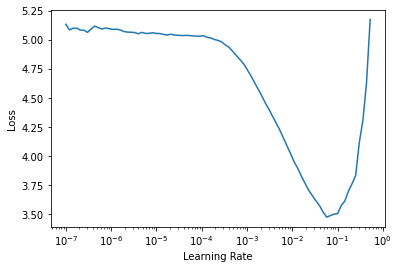

In [32]:
learn = Learner(dls, model, metrics=accuracy, path=".").to_fp16()
learn.lr_find()

In [33]:
learn.fit_one_cycle(5, 1e-3, wd=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.883909,0.433452,0.892421,02:59
1,0.466446,0.338898,0.901711,03:00
2,0.370352,0.289116,0.908068,03:00
3,0.260682,0.237924,0.925183,03:00
4,0.196238,0.223895,0.925183,03:00


# Summary

This model can reach a fairly good accuracy with only 5 epochs (roughly 15 minutes), which is quite efficient. It outperforms a deeper single model by higher accuracy and less training time. This reason why it can do this might be the variety of features. That is, these pretrained CNNs learn different features from the image, so our classifier can learn better with these abundant features. What I've learned from this project is that a "wider" can do better than a "deeper" model, so getting your model deeper and deeper is not the only choice to make you model more poweerful.